In [1]:
import os
from os.path import basename, dirname, join, exists
import glob
import sys
import time
from importlib import reload

import numpy as np
import numpy.ma as ma
import scipy.stats as stats
import pandas as pd
import geopandas as gpd

# 1d so the smoothing is specific to each realization
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import minimize


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as lines



In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
    
git_dir = join(doc_dir,'GitHub','CosumnesRiverRecharge')
# dir of all gwfm data
gwfm_dir = join(dirname(doc_dir),'Box/research_cosumnes/GWFlowModel')

def add_path(fxn_dir):
    if fxn_dir not in sys.path:
        sys.path.append(fxn_dir)
        
add_path(doc_dir+'/GitHub/flopy')
import flopy 
import flopy.utils.binaryfile as bf

add_path(doc_dir+'/GitHub/CosumnesRiverRecharge/tprogs_utilities')
add_path(doc_dir+'/GitHub/CosumnesRiverRecharge/python_utilities')

In [3]:
# set box directory for output figures and data
box_dir = gwfm_dir+'/Levee_setback/levee_setback_distance_analysis/'

# tprogs_id = '' # original tprogs with conditioning data in output tsim
# tprogs_id = '_no_conditioning'
tprogs_id = '_no_cond_c3d'

proj_dir = join(box_dir, tprogs_id)

data_dir = join(proj_dir,'data_output/')
fig_dir = join(proj_dir,'figures/')

chan_dir = box_dir+'channel_data/'
gis_dir = chan_dir+'GIS/'

In [4]:
dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_mean.tsv')


<>:1: DeprecationWarning: invalid escape sequence '\D'
<>:1: DeprecationWarning: invalid escape sequence '\D'
C:\Users\andrewc\AppData\Local\Temp\ipykernel_7064\2785683405.py:1: DeprecationWarning: invalid escape sequence '\D'
  dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_mean.tsv')


In [5]:
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')

m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')

In [7]:
setbacks = np.arange(0, 3400,200)
# original XS data
xs_all_df = pd.read_csv(chan_dir+'Elevation_by_XS_number_meters.csv')
xs_all_df = xs_all_df.assign(dist_from_center_m=xs_all_df.dist_from_right_m-3300)
xs_all_df = xs_all_df.set_index('dist_from_center_m').drop(columns='dist_from_right_m')
# smoothed XS data used for setback analysis
xs_levee_smooth = pd.read_csv(chan_dir+'xs_levee_smooth.csv')
xs_levee_smooth = xs_levee_smooth.assign(dist_from_center_m=xs_levee_smooth.dist_from_right_m-3300)
xs_levee_smooth = xs_levee_smooth.set_index('dist_from_center_m').drop(columns='dist_from_right_m')

num_segs = xs_levee_smooth.shape[1]

# load array identifying row,col to XS id (1,28)
xs_arr = np.loadtxt(chan_dir+'XS_num_grid_reference.tsv')

# load flood typology characteristics (based on daily data 1908 - 2014) - median values 
#"cms_pk" for peak discharge, "pk_loc" for time to peak, and "log_no_d" for duration
flood_type = pd.read_csv(join(box_dir, 'whipple_grp6_w97ftmedians.csv'),index_col='Group.1')


In [8]:
from muskingum_recharge import min_Q, mannings, calc_depth_arr, gridded_interpolation, xs_setback, mannings_v


In [9]:
# find minimum from channel center
xs_mins = xs_levee_smooth.loc[-100:100].min(axis=0)
xs_mins.index = xs_mins.index.astype(int)
# xs_mins.interpolate(method='linear').plot()
slope = xs_mins.diff().rolling(2, center=True, closed='right').mean().bfill()/2000*-1
adj_xs_mins = np.append(xs_mins[0], (xs_mins[0]-slope.cumsum()*2000))


## Rating curves for each segment and setback (50-points)
50 point rating curves to match modflow format.

In [31]:
segs = np.arange(0, xs_levee_smooth.shape[1])

xs_flow_all = pd.DataFrame(columns=['nseg','setback','depth_m','flow_cms']).set_index(['nseg','setback','depth_m'])
# original code takes 5-10 seconds, the slowness is from the loops and mannings equation, not the dataframe setup

n= 0.048
# iterate over cross-section segments
for nseg in segs:
    # nseg = 15
    df = xs_levee_smooth[str(nseg)]
    # iterate over the stream segments
    for setback in setbacks:
    # setback = 3200
        # maximum depth is tallest height of cross-section minus lowest point, flow above will run out of the channel
        xs_elevs = xs_setback(xs_levee_smooth.iloc[:,nseg].copy(), setback, 30)
        dmax = xs_elevs.max()-xs_elevs.min()
        for d in np.linspace(0.01, dmax, 50):
            flow = mannings(d, xs_elevs, n, slope.iloc[nseg])
            xs_flow_all.loc[(nseg, setback, d),'flow_cms'] = flow

In [33]:
xs_flow_all.reset_index().to_csv(join(chan_dir,'all_xs_50pt_rating_curves.csv'), index=False)

## Given flow return depth

In [ ]:
def depth_match(seg_flow, flow):
    """ Given a XS (nseg, setback) return the expected depth (m) given a flow (cms)"""
    # find flows above and below the input flow
    flow_diff = (seg_flow.flow_cms-flow)
    f_high = flow_diff[flow_diff>0].argsort().index[0]
    f_low = flow_diff[flow_diff<0].argsort().index[-1]
    match_d = seg_flow.loc[[f_low, f_high]].sort_values('flow_cms')
    # linearly interpolate to calculate exact depth
    flow_slope = (match_d.iloc[1].flow_cms-match_d.iloc[0].flow_cms)/(match_d.iloc[1].depth_m-match_d.iloc[0].depth_m)
    out_depth = match_d.iloc[0].depth_m + (flow-match_d.iloc[0].flow_cms)/flow_slope
    return(out_depth)

In [ ]:
nseg = 10
setback=3200
seg_flow = xs_flow_all[(xs_flow_all.nseg==nseg)&(xs_flow_all.setback==setback)]
# seg_flow
depth_match(seg_flow, flow=500)

# Recreate DEM with updated XS points

In [27]:
xs_all = pd.read_csv(chan_dir+'XS_point_subsegments_elevations.csv') # every 200 m
# xs_all = pd.read_csv(chan_dir+'XS_point_elevations.csv', index_col=0) #every 2 km

xs_all['dist_from_center_m'] = xs_all.dist_from_right_m - 3300


In [28]:
xs_all_df = pd.read_csv(chan_dir+'Elevation_by_XS_number_subsegments_meters.csv')# every 200 m
# xs_all_df = pd.read_csv(chan_dir+'Elevation_by_XS_number_meters.csv')#every 2 km
xs_all_df = xs_all_df.assign(dist_from_center_m=xs_all_df.dist_from_right_m-3300)
xs_all_df = xs_all_df.set_index('dist_from_center_m').drop(columns='dist_from_right_m')

In [29]:
dline=10
roll_window=400
# channel_middle = int(len(xs_all_df)/2)*dline
channel_middle = np.median(xs_all_df.index.values)
channel_bool = (xs_all_df.index >= channel_middle - (roll_window/2))& (xs_all_df.index <= channel_middle + (roll_window/2))


In [30]:
roll_window = 200
xs_roll_mean = xs_all_df.rolling(int(roll_window/dline), center=True, min_periods=1).mean()


In [33]:
xs_roll_mean.columns

Index(['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0',
       ...
       '266.0', '267.0', '268.0', '269.0', '270.0', '271.0', '272.0', '273.0',
       '274.0', '275.0'],
      dtype='object', length=276)

<Axes: xlabel='dist_from_center_m'>

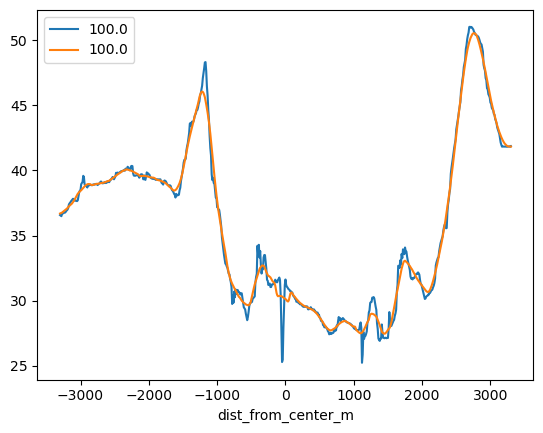

In [35]:
# xs= '10'
xs='100.0'
fig, ax = plt.subplots()
xs_all_df.plot(y=xs, ax=ax)
xs_roll_mean.plot(y=xs, ax=ax)

In [13]:
xs_roll_long = xs_roll_mean.melt(var_name='xs_num', value_name = 'z_roll_m', ignore_index=False)
xs_roll_long.xs_num = xs_roll_long.xs_num.astype(int)
# xs_roll_long.z_adj_m = xs_roll_long.z_adj_m.astype(int)

In [14]:
xs_all_roll = xs_all.merge(xs_roll_long, on=['xs_num','dist_from_center_m'])
xs_all_roll = xs_all_roll.dropna(subset='z_roll_m')

In [15]:
x_in = xs_all_roll.Easting
y_in = xs_all_roll.Northing
z_in = xs_all_roll.z_roll_m

It seems like griddata is a reasonable method to convert the XS data back to a raster format. This should be done with the XS from every 200 m, not just the every 2,000 m XS. The griddata doesn't extend all the way to the model edge because the Cosumnes River ends at the Mokelumne.   

Will there need to be an adjusted DEM for each setback? If the rolling mean values are the same for all setbacks then in the model the DEM is already cropped to the active setback area so it shouldn't matter that the outer area is adjusted as well.

In [16]:
from scipy.interpolate import griddata

In [17]:
x_out = grid_p.geometry.centroid.x.values
y_out = grid_p.geometry.centroid.y.values
out_xy = np.transpose(np.vstack((x_out, y_out)))

in_xy = np.transpose(np.vstack([x_in, y_in]))

grid = griddata(in_xy, z_in, xi = out_xy,
            method = 'linear') 

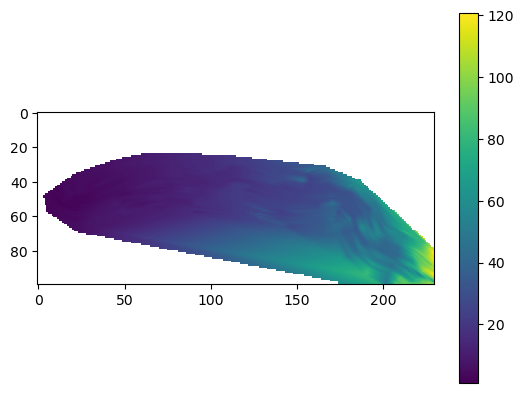

In [26]:
new_z = grid_p.copy()
new_z['z_roll_m'] = grid
arr_z = np.zeros((new_z.row.max(),new_z.column.max()))
arr_z[new_z.row-1, new_z.column-1] = new_z.z_roll_m
plt.imshow(arr_z)
plt.colorbar()

In [ ]:
# going from XS to kriging is incredibly slow, didn't finish after a few minutes

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.05694573533814316
Nugget: 1.9128752606491326e-11 



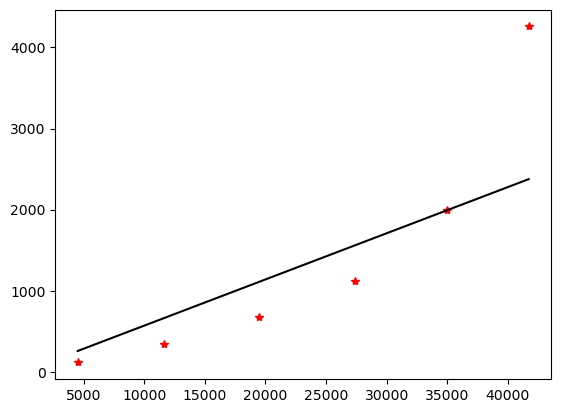

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [ ]:
# from pykrige.ok import OrdinaryKriging
# # x_in = df.geometry.x.values
# # y_in = df.geometry.y.values
# # z_in = df[z_name].values
# x_in = xs_all_roll.Easting
# y_in = xs_all_roll.Northing
# z_in = xs_all_roll.z_roll_m

# res = 100
# gridx = np.arange(np.min(x_in), np.max(x_in), res)
# gridy = np.arange(np.min(y_in), np.max(y_in), res)

# # Kriging
# # linear, gaussian, spherical, exponential, hole-effect and power
# OK = OrdinaryKriging(
#     x_in,
#     y_in,
#     z_in,
#     # gaussian overweights low values causing all data to look the same, power looks okay with high lag
#     # linear still seems best if I can avoid the singular matrix issue
#     variogram_model="linear", 
#     verbose=True,
#     enable_plotting=True,
# #     exact_values = False,
#     enable_statistics = False,
#     # 50 lags seems a little higher
#     nlags = 6, # if lags is too low, then higher values seem to dominate?
#     pseudo_inv=True
# )


# # z is the kriged grid and ss is the variance grid (sigma ^2)
# z, ss = OK.execute("grid", gridx, gridy)
# # flip data because np sets 0,0 in top left while raster is bottom left
# Z  = np.flip(z.data,axis = 0)
# SS = np.flip(ss.data,axis = 0)